# 2: Text Mining


This section we will be using the Latent Dirichlet Allocation (LDA) model to uncover hidden structures in the description variable for each dataset. The description variable wil be visualized in both a wordcloud and intertopic distance map. These graphs will help visualize the most frequent terms for the description of each listing.

The Wordclouds and HTML files can be found in the folders on the main branch. To run for each city, the df must changed for the corpus variable. For example, corpus = df_tor[descript] would be used for Toronto whereas corpus = df_van[descript] would be used for Vancouver.

In [1]:
import pandas as pd
import os
import re
import numpy as np


In [2]:
path = ('LA_listings.csv')
df = pd.read_csv(path, header=0, index_col=0)
descript = ['description']
corpus = df[descript]
corpus.head()

,description
id,
109,"*** Unit upgraded with new bamboo flooring, br..."
2708,"Run Runyon Canyon, Our Gym & Sauna Open Beauti..."
2732,An oasis of tranquility awaits you.The spaceTh...
2864,Centrally located.... Furnished with King Size...
5728,Our home is located near Venice Beach without ...


In [3]:
import nltk

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel

import itertools
from collections import Counter
from collections import defaultdict

import json
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [4]:
def preprocess_text(corpus):
    clean_corpus = []
    en_words = set(nltk.corpus.words.words())
    en_stopwords = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[\w|!]+')
    for row in corpus:
        word_tokens = tokenizer.tokenize(row)
        word_tokens_lower = [t.lower() for t in word_tokens]
        word_tokens_lower_en = [t for t in word_tokens_lower if t in en_words or not t.isalpha()]
        word_tokens_no_stops = [t for t in word_tokens_lower_en if not t in en_stopwords]
        word_tokens_no_stops_lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in word_tokens_no_stops]
        clean_corpus.append(word_tokens_no_stops_lemmatized)
    return clean_corpus
def nlp_model_pipeline(clean_corpus):
    dictionary = Dictionary(clean_corpus)
    doc_term_matrix = [dictionary.doc2bow(listing) for listing in clean_corpus]    
    return dictionary, doc_term_matrix
def LDA_topic_modelling(doc_term_matrix, dictionary, num_topics=3, passes=2):
    LDA = LdaModel
    ldamodel = LDA(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=passes)
    return ldamodel
def add_topics_to_df(ldamodel, doc_term_matrix, df, new_col, num_topics):
    docTopicProbMat = ldamodel[doc_term_matrix]
    docTopicProbDf = pd.DataFrame(index=df.index, columns=range(0, num_topics))
    for i, doc in enumerate(docTopicProbMat):
        for topic in doc:
            docTopicProbDf.iloc[i, topic[0]] = topic[1]
    docTopicProbDf[new_col] = docTopicProbDf.idxmax(axis=1)
    df_topics = docTopicProbDf[new_col]
    df_new = pd.concat([df, df_topics], axis=1)
    return df_new

In [5]:
corpus_description = corpus['description'].astype(str)
new_corpus = preprocess_text(corpus_description)
dictionary_description, doc_term_matrix_description = nlp_model_pipeline(new_corpus)

In [6]:
ldamodel_description = LDA_topic_modelling(doc_term_matrix_description, dictionary_description, num_topics=3, passes=10)

In [7]:
ch = gensimvis.prepare(ldamodel_description, doc_term_matrix_description, dictionary_description)

C:\Users\conno\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [8]:
pyLDAvis.save_html(ch, 'laLDA.html')

In [9]:
from wordcloud import WordCloud
canvas_width=1280
canvas_height=720
long_string = ','.join(list(corpus_description))
wordcloud = WordCloud(width=canvas_width,height=canvas_height,background_color="white", max_words=50000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_file('LA_wordcloud.png')

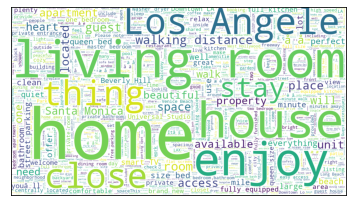

In [12]:
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.pyplot as plt
img = mpimg.imread('la_wordcloud.png') #LA Wordcloud
imgplot = plt.imshow(img)
x_axis = imgplot.axes.get_xaxis()
x_axis.set_visible(False)

y_axis = imgplot.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()